In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd "/content/drive/My Drive/FakeNewsChallenge/data"

/content/drive/My Drive/FakeNewsChallenge/data


In [4]:
%matplotlib inline

# from __future__ import print_function

import numpy as np
from sklearn.model_selection import train_test_split
from dataproc_utils import load_wordvecs, load_file, read_proc_data
from dataproc_utils import make_word_freq_V, word2idx
from dataproc_utils import vocab_vectorizer, random_sampler
from tfidf_cosine_similarity import tfidf_fit_transform

import keras
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, Reshape, Dropout
from keras.layers import dot, multiply, concatenate
from keras.layers import LSTM, Conv1D, TimeDistributed, Lambda
from keras.initializers import Constant
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from dataproc_utils import plot_confusion_matrix, compute_weighted_accuracy

from collections import Counter
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


# Global variables

In [0]:
batch_size = 128
epochs = 15
random_state = 42
n_pars = 9 # max number of paragraphs from each document
par_size = 15  # max paragraph length (num of words in each paragraph)
claim_size = 15  # max num of words in each claim
embedding_dim = 100  # size of the pre-trained glove embeddings
output_size = 4  # size of the output vector, corresponds to the number of classes

# Embeddings from Glove

Only the words we use

In [6]:
# open saved wordvecs from file
w2v = load_wordvecs('train_wordvecs100d.txt')
print(len(w2v), 'pretrained embeddings')

# load data and labels
bodies_train = load_file('train_bodies.txt')
claims_train = load_file('train_claims.txt')
bodies_test = load_file('test_bodies.txt')
claims_test = load_file('test_claims.txt')

data_train = read_proc_data(bodies_train, claims_train, split_pars=True)
y_train = np.array([label for _, _, label in data_train])

data_test = read_proc_data(bodies_test, claims_test, split_pars=True)
y_test = np.array([label for _, _, label in data_test])

# train/validation split
train_data, val_data, train_labels, val_labels = train_test_split(data_train, y_train,
                                                                  test_size=.2,
                                                                  random_state=random_state)

# compute cos similarities after splitting into train/val or load the precomputed ones
# you have to recompute the similarities each time you change the random state or size of train/val split
# train_p_tfidf, val_p_tfidf, test_p_tfidf = tfidf_fit_transform(train_data, val_data, data_test)

# load pre-computed p_tfidf similarity matrix for train data
train_p_tfidf = np.loadtxt('p_tfidf_train.txt', dtype=np.float32)
val_p_tfidf = np.loadtxt('p_tfidf_val.txt', dtype=np.float32)
test_p_tfidf = np.loadtxt('p_tfidf_test.txt', dtype=np.float32)
print('Shape of similarity matrix train p_tfidf:', train_p_tfidf.shape)


# create a vocabulary dict from train data (we exclude rare words, which appear only once)
word2freq = make_word_freq_V(train_data, fmin=1)
word2index = word2idx(word2freq, pretrained=w2v)
vocab_size = len(word2index)
print('Vocab size:', vocab_size, 'unique words in the train set which have glove embeddings')

# vectorize input words (turn each word into its index from the word2index dict)
# for new words in test set that don't appear in train set, use index of <unknown>
train_body, train_claim = vocab_vectorizer(train_data, word2index, max_par_len=par_size, max_claim_len=claim_size)
val_body, val_claim = vocab_vectorizer(val_data, word2index, max_par_len=par_size, max_claim_len=claim_size)
test_body, test_claim = vocab_vectorizer(data_test, word2index, max_par_len=par_size, max_claim_len=claim_size)

17354 pretrained embeddings
Shape of similarity matrix train p_tfidf: (39977, 9)
Vocab size: 17256 unique words in the train set which have glove embeddings


# Oversampling

In [0]:
# perform random under/over sampling to prevent class imbalance
# over-sampling shows better results
train_body, train_claim, train_p_tfidf, train_labels = random_sampler(train_body,
                                                                      train_claim,
                                                                      train_p_tfidf,
                                                                      train_labels, type='over')

In [0]:
np.save('bodies.npy', [train_body, val_body, test_body])
np.save('claims.npy', [train_claim, val_claim, test_claim])
np.save('ptfidf.npy', [train_p_tfidf, val_p_tfidf, test_p_tfidf])
np.save('labels.npy', [train_labels, val_labels, y_test])

In [0]:
train_body, val_body, test_body = np.load('bodies.npy',allow_pickle=True)
train_claim, val_claim, test_claim = np.load('claims.npy',allow_pickle=True)
train_p_tfidf, val_p_tfidf, test_p_tfidf = np.load('ptfidf.npy',allow_pickle=True)
train_labels, val_labels, test_labels = np.load('labels.npy',allow_pickle=True)

In [0]:
# prepare embedding matrix
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for w, i in word2index.items():
    embedding_matrix[i] = w2v[w]

# Embeddings

In [11]:
# load pre-trained word vectors into embedding layers
# we set trainable to false to keep the embeddings fixed
embedding_body = Embedding(vocab_size + 1,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=(n_pars, par_size,),
                            trainable=False)

embedding_claim = Embedding(vocab_size + 1,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=claim_size,
                            trainable=False)

W0809 00:40:36.857644 139906275555200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [12]:
# initialize input placeholders and embed pre-trained word vectors
input_body = Input(shape=(n_pars, par_size,), dtype='int32', name='docs')
input_claim = Input(shape=(claim_size,), dtype='int32', name='claims')
input_p_tfidf = Input(shape=(n_pars,), dtype='float32', name='tfidf')

print('input body', input_body.shape)     # (?, 9, 15)
print('input claim', input_claim.shape)    # (?, 15)
print('input p_tfidf', input_p_tfidf.shape)  # (?, 9)

W0809 00:40:36.901486 139906275555200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



input body (?, 9, 15)
input claim (?, 15)
input p_tfidf (?, 9)


In [13]:
embedded_body = embedding_body(input_body)
embedded_claim = embedding_claim(input_claim)

print('embedded body', embedded_body.shape)   # (?, 9, 15, 25)
print('embedded claim', embedded_claim.shape)  # (?, 15, 25)

embedded body (?, 9, 15, 100)
embedded claim (?, 15, 100)


# LSTMs

- TimeDistributed for documents
- simple for claims

In [14]:
# train two lstms
lstm_body = TimeDistributed(LSTM(100), name="LSTM_docs")(embedded_body)
lstm_claim = (LSTM(100, name="LSTM_claims"))(embedded_claim)

print('lstm body', lstm_body.shape) # (?, 9, 100)
print('lstm claim', lstm_claim.shape) # (?, 100)

W0809 00:40:36.981395 139906275555200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



lstm body (?, 9, 100)
lstm claim (?, 100)


In [15]:
# reshape tfidf sim matrix layer from (?, 9) into (?, 9, 1)
reshaped_p_tfidf = Reshape((n_pars, 1), name="reshape_tfidf")(input_p_tfidf)
lstm_body = multiply([lstm_body, reshaped_p_tfidf], name="")
### tensor shapes: (samples, n_pars, 100) * (samples, n_pars, 1) => (?, 9, 100)
print('lstm_body * p_tfidf', lstm_body.shape)  # (?, 9, 100)

lstm_body * p_tfidf (?, 9, 100)


# sMemLstm (dotProduct)

In [16]:
## p_lstm = lstm_claim.T x M x lstm_body[j] 
## if normalize=True, then the output of the dot product is the cosine similarity between the two samples
p_lstm = dot([lstm_body, lstm_claim], axes=(2, 1), normalize=True, name="P_lstm")
print('p_lstm', p_lstm.shape)  # (samples, 9)

p_lstm (?, 9)


In [0]:
### cnn_body = cnn_body * p_lstm
# reshape sim matrix layer from (?, 9) into (?, 9, 1)
p_lstm = Reshape((n_pars, 1), name="P_lstm_reshape")(p_lstm)

In [18]:
print('p_lstm', p_lstm.shape)  # (samples, 9)

p_lstm (?, 9, 1)


# O

In [0]:
# taking mean and max similarities
max_p_lstm = Lambda(lambda x: K.max(x, axis=1), name="max_p_lstm")(p_lstm)
mean_p_lstm = Lambda(lambda x: K.mean(x, axis=1), name="mean_p_lstm")(p_lstm)
max_p_tfidf = Lambda(lambda x: K.max(x, axis=1), name="max_p_tfidf")(reshaped_p_tfidf)
mean_p_tfidf = Lambda(lambda x: K.mean(x, axis=1), name="mean_p_tfidf")(reshaped_p_tfidf)

In [20]:
output = concatenate([max_p_lstm, mean_p_lstm,
                      max_p_tfidf, mean_p_tfidf],
                      name="O_concatenate")

print('output', output.shape)  # (?, 15)

output (?, 4)


In [21]:
response = concatenate([output, lstm_claim], name="input_for_dense_R")
print('response layer:', response.shape)   # (?, 126)

response layer: (?, 104)


In [22]:
# home stretch
stance = Dense(300, activation='relu', name="dense")(response)
stance = Dropout(0.7)(stance)
preds = Dense(output_size, activation='softmax')(stance)

W0809 00:40:37.785936 139906275555200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0809 00:40:37.795150 139906275555200 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0809 00:40:37.796017 139906275555200 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [23]:
# build the model
model = Model([input_body, input_claim, input_p_tfidf], preds)
model.compile(optimizer=keras.optimizers.adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

W0809 00:40:37.844597 139906275555200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0809 00:40:37.851127 139906275555200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3341: The name tf.log is deprecated. Please use tf.math.log instead.



# Diagram of model

In [0]:
# uncomment the line below to plot the model diagram (requires graphviz)
keras.utils.plot_model(model, to_file='../material/lstm_model.png', show_shapes=True)

# Train

In [0]:
filepath="lstm_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [44]:
# train
history = model.fit(
    [train_body, train_claim, train_p_tfidf], train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_body, val_claim, val_p_tfidf], val_labels),
    callbacks=[checkpoint],
    verbose=2
         )

Train on 116848 samples, validate on 9995 samples
Epoch 1/15
 - 43s - loss: 0.0260 - acc: 0.9912 - val_loss: 0.2473 - val_acc: 0.9607

Epoch 00001: val_acc improved from -inf to 0.96068, saving model to lstm_model.hdf5
Epoch 2/15
 - 43s - loss: 0.0277 - acc: 0.9919 - val_loss: 0.2493 - val_acc: 0.9581

Epoch 00002: val_acc did not improve from 0.96068
Epoch 3/15
 - 42s - loss: 0.0181 - acc: 0.9937 - val_loss: 0.2457 - val_acc: 0.9609

Epoch 00003: val_acc improved from 0.96068 to 0.96088, saving model to lstm_model.hdf5
Epoch 4/15
 - 43s - loss: 0.0200 - acc: 0.9929 - val_loss: 0.2560 - val_acc: 0.9586

Epoch 00004: val_acc did not improve from 0.96088
Epoch 5/15
 - 42s - loss: 0.0174 - acc: 0.9941 - val_loss: 0.2636 - val_acc: 0.9576

Epoch 00005: val_acc did not improve from 0.96088
Epoch 6/15
 - 42s - loss: 0.0185 - acc: 0.9937 - val_loss: 0.2545 - val_acc: 0.9586

Epoch 00006: val_acc did not improve from 0.96088
Epoch 7/15
 - 42s - loss: 0.0186 - acc: 0.9934 - val_loss: 0.2462 - v

In [45]:
test_claim.shape, y_test.shape

((25413, 15), (25413,))

In [0]:
model.load_weights(filepath)

In [0]:
preds = model.predict([test_body, test_claim, test_p_tfidf])

In [0]:
preds = np.argmax(preds, axis=1)

# Metrics

In [49]:
f1_score(y_test, preds, average='macro')

0.5105442123331259

In [50]:
precision_recall_fscore_support(y_test, preds, average=None)

(array([0.96257625, 0.63868613, 0.37263407, 0.09090909]),
 array([0.95460243, 0.66644265, 0.49658434, 0.00286944]),
 array([0.95857276, 0.65226924, 0.42577157, 0.00556328]),
 array([18349,  4464,  1903,   697]))

In [51]:
precision_recall_fscore_support(y_test, preds, average='macro')

(0.5162013851322022, 0.5301247159885019, 0.5105442123331259, None)

In [0]:
score = model.evaluate([test_body, test_claim, test_p_tfidf], y_test, batch_size=batch_size, verbose=2)

# Evaluation

In [0]:
LABELS = ['unrelated','discuss','agree','disagree']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[1:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm


def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))


def report_score(actual,predicted):
    score,cm = score_submission(actual,predicted)
    best_score, _ = score_submission(actual,actual)

    print_confusion_matrix(cm)
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score

In [54]:
report_score([LABELS[e] for e in y_test],[LABELS[e] for e in preds])

-------------------------------------------------------------
|           | unrelated |  discuss  |   agree   | disagree  |
-------------------------------------------------------------
| unrelated |   17516   |    560    |    258    |    15     |
-------------------------------------------------------------
|  discuss  |    430    |   2975    |   1056    |     3     |
-------------------------------------------------------------
|   agree   |    140    |    816    |    945    |     2     |
-------------------------------------------------------------
| disagree  |    111    |    307    |    277    |     2     |
-------------------------------------------------------------
Score: 8768.5 out of 11477.0	(76.4006273416398%)


76.4006273416398

In [0]:
import pickle
lables = [LABELS[e] for e in preds]
with open('../pure_lstm_labels.pickle', 'wb') as f:
        pickle.dump(lables, f, pickle.HIGHEST_PROTOCOL)

# Confusion matrix

In [56]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.369380473133637
Test accuracy: 0.8435839924283937


Normalized confusion matrix


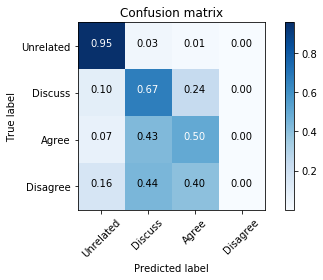

In [57]:
cnf_matrix = confusion_matrix(y_test, preds)
fig = plot_confusion_matrix(cnf_matrix, ['Unrelated','Discuss','Agree','Disagree'], normalize=True)
plt.savefig('../material/lstm_model_confusion_matrix.png')

# Balancing the results

In [58]:
compute_weighted_accuracy(y_test, preds)

0.7652612380645853

# Plot training

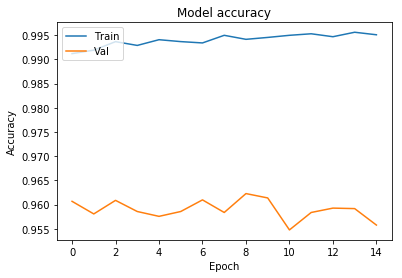

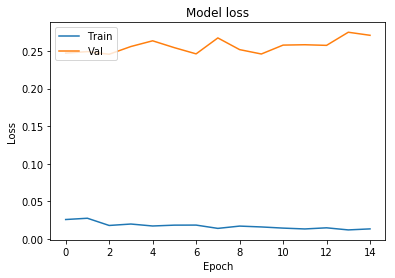

In [59]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
# plt.savefig('../material/model_accuracy.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
# plt.savefig('../material/model_loss.png')
plt.show()
